## API KEY

In [16]:
import requests
import base64

# Replace with your own Client ID and Client Secret
CLIENT_ID = 'd0ef8242c2b849109ee01b9936c47538'
CLIENT_SECRET = '3157df338a4542abac1d6458d32f5eba'

# Base64 encode the client ID and client secret
client_credentials = f"{CLIENT_ID}:{CLIENT_SECRET}"
client_credentials_base64 = base64.b64encode(client_credentials.encode())

# Request the access token
token_url = 'https://accounts.spotify.com/api/token'
headers = {
    'Authorization': f'Basic {client_credentials_base64.decode()}'
}
data = {
    'grant_type': 'client_credentials'
}
response = requests.post(token_url, data=data, headers=headers)

if response.status_code == 200:
    access_token = response.json()['access_token']
    print("Access token obtained successfully.")
else:
    print("Error obtaining access token.")
    exit()

Access token obtained successfully.


In [5]:
pip install spotipy

Note: you may need to restart the kernel to use updated packages.


## Creating DataFrame

In [17]:
import pandas as pd
import spotipy
from spotipy.oauth2 import SpotifyOAuth

def get_trending_playlist_data(playlist_id, access_token):
    # Set up Spotipy with the access token
    sp = spotipy.Spotify(auth=access_token)

    # Get the tracks from the playlist
    playlist_tracks = sp.playlist_tracks(playlist_id, fields='items(track(id, name, artists, album(id, name)))')

    # Extract relevant information and store in a list of dictionaries
    music_data = []
    for track_info in playlist_tracks['items']:
        track = track_info['track']
        track_name = track['name']
        artists = ', '.join([artist['name'] for artist in track['artists']])
        album_name = track['album']['name']
        album_id = track['album']['id']
        track_id = track['id']

        # Get audio features for the track
        audio_features = sp.audio_features(track_id)[0] if track_id != 'Not available' else None

        # Get release date of the album
        try:
            album_info = sp.album(album_id) if album_id != 'Not available' else None
            release_date = album_info['release_date'] if album_info else None
        except:
            release_date = None

        # Get popularity of the track
        try:
            track_info = sp.track(track_id) if track_id != 'Not available' else None
            popularity = track_info['popularity'] if track_info else None
        except:
            popularity = None

        # Add additional track information to the track data
        track_data = {
            'Track Name': track_name,
            'Artists': artists,
            'Album Name': album_name,
            'Album ID': album_id,
            'Track ID': track_id,
            'Popularity': popularity,
            'Release Date': release_date,
            'Duration (ms)': audio_features['duration_ms'] if audio_features else None,
            'Explicit': track_info.get('explicit', None),
            'External URLs': track_info.get('external_urls', {}).get('spotify', None),
            'Danceability': audio_features['danceability'] if audio_features else None,
            'Energy': audio_features['energy'] if audio_features else None,
            'Key': audio_features['key'] if audio_features else None,
            'Loudness': audio_features['loudness'] if audio_features else None,
            'Mode': audio_features['mode'] if audio_features else None,
            'Speechiness': audio_features['speechiness'] if audio_features else None,
            'Acousticness': audio_features['acousticness'] if audio_features else None,
            'Instrumentalness': audio_features['instrumentalness'] if audio_features else None,
            'Liveness': audio_features['liveness'] if audio_features else None,
            'Valence': audio_features['valence'] if audio_features else None,
            'Tempo': audio_features['tempo'] if audio_features else None,
            # Add more attributes as needed
        }

        music_data.append(track_data)

    # Create a pandas DataFrame from the list of dictionaries
    df = pd.DataFrame(music_data)

    return df

In [12]:
try:
    audio_features = sp.audio_features(track_id)[0] if track_id != 'Not available' else None
except SpotifyException as e:
    print(f"Spotify API error: {e}")
    audio_features = None


NameError: name 'SpotifyException' is not defined

## Choosing Playlist

In [18]:
playlist_id = '5ABHKGoOzxkaa28ttQV9sE' #That's the top 100 popular songs on Spotify

# Call the function to get the music data from the playlist and store it in a DataFrame
music_df = get_trending_playlist_data(playlist_id, access_token)

# Display the DataFrame
print(music_df)

HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=0VjIjW4GlUZAMYd2vXMi3b with Params: {} returned 403 due to None


SpotifyException: http status: 403, code:-1 - https://api.spotify.com/v1/audio-features/?ids=0VjIjW4GlUZAMYd2vXMi3b:
 None, reason: None

In [57]:
print(music_df.isnull().sum())

Track Name          0
Artists             0
Album Name          0
Album ID            0
Track ID            0
Popularity          0
Release Date        0
Duration (ms)       0
Explicit            0
External URLs       0
Danceability        0
Energy              0
Key                 0
Loudness            0
Mode                0
Speechiness         0
Acousticness        0
Instrumentalness    0
Liveness            0
Valence             0
Tempo               0
dtype: int64


## Tunning Features for Recommendations

In [58]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from sklearn.metrics.pairwise import cosine_similarity

data = music_df

In [59]:
# Function to calculate weighted popularity scores based on release date
def calculate_weighted_popularity(release_date):
    # Convert the release date to datetime object
    release_date = datetime.strptime(release_date, '%Y-%m-%d')

    # Calculate the time span between release date and today's date
    time_span = datetime.now() - release_date

    # Calculate the weighted popularity score based on time span (e.g., more recent releases have higher weight)
    weight = 1 / (time_span.days + 1)
    return weight

In [60]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the music features using Min-Max scaling
scaler = MinMaxScaler()
music_features = music_df[['Danceability', 'Energy', 'Key', 
                           'Loudness', 'Mode', 'Speechiness', 'Acousticness',
                           'Instrumentalness', 'Liveness', 'Valence', 'Tempo']].values
music_features_scaled = scaler.fit_transform(music_features)

In [61]:
# a function to get content-based recommendations based on music features
def content_based_recommendations(input_song_name, num_recommendations=5):
    if input_song_name not in music_df['Track Name'].values:
        print(f"'{input_song_name}' not found in the dataset. Please enter a valid song name.")
        return

    # Get the index of the input song in the music DataFrame
    input_song_index = music_df[music_df['Track Name'] == input_song_name].index[0]

    # Calculate the similarity scores based on music features (cosine similarity)
    similarity_scores = cosine_similarity([music_features_scaled[input_song_index]], music_features_scaled)

    # Get the indices of the most similar songs
    similar_song_indices = similarity_scores.argsort()[0][::-1][1:num_recommendations + 1]

    # Get the names of the most similar songs based on content-based filtering
    content_based_recommendations = music_df.iloc[similar_song_indices][['Track Name', 'Artists', 'Album Name', 'Release Date', 'Popularity']]

    return content_based_recommendations

In [ ]:
def hybrid_recommendations(input_song_name, num_recommendations=5, alpha=0.5):
    if input_song_name not in music_df['Track Name'].values:
        print(f"'{input_song_name}' not found in the dataset. Please enter a valid song name.")
        return

    # Get content-based recommendations
    content_based_rec = content_based_recommendations(input_song_name, num_recommendations)

    # Get the popularity score of the input song
    popularity_score = music_df.loc[music_df['Track Name'] == input_song_name, 'Popularity'].values[0]

    # Calculate the weighted popularity score
    weighted_popularity_score = popularity_score * calculate_weighted_popularity(music_df.loc[music_df['Track Name'] == input_song_name, 'Release Date'].values[0])

    # Create a DataFrame for the input song
    input_song_data = {
        'Track Name': [input_song_name],
        'Artists': [music_df.loc[music_df['Track Name'] == input_song_name, 'Artists'].values[0]],
        'Album Name': [music_df.loc[music_df['Track Name'] == input_song_name, 'Album Name'].values[0]],
        'Release Date': [music_df.loc[music_df['Track Name'] == input_song_name, 'Release Date'].values[0]],
        'Popularity': [weighted_popularity_score]
    }
    input_song_df = pd.DataFrame(input_song_data)

    # Concatenate the input song DataFrame with content-based recommendations
    hybrid_recommendations = pd.concat([content_based_rec, input_song_df], ignore_index=True)

    # Sort the hybrid recommendations based on weighted popularity score
    hybrid_recommendations = hybrid_recommendations.sort_values(by='Popularity', ascending=False)

    # Remove the input song from the recommendations
    hybrid_recommendations = hybrid_recommendations[hybrid_recommendations['Track Name'] != input_song_name]

    return hybrid_recommendations

## Recommendation Song List

In [63]:
input_song_name = "Blinding Lights"
recommendations = hybrid_recommendations(input_song_name, num_recommendations=5)
print(f"Hybrid recommended songs for '{input_song_name}':")
print(recommendations.to_string(index=False))

Hybrid recommended songs for 'Blinding Lights':
                      Track Name                                                     Artists             Album Name Release Date  Popularity
                  Mr. Brightside                                                 The Killers               Hot Fuss         2004        85.0
Can't Hold Us (feat. Ray Dalton) Macklemore, Ryan Lewis, Macklemore & Ryan Lewis, Ray Dalton              The Heist   2012-10-09        76.0
                          Demons                                             Imagine Dragons Night Visions (Deluxe)   2012-09-04        19.0
       STAY (with Justin Bieber)                                The Kid LAROI, Justin Bieber  F*CK LOVE 3: OVER YOU   2021-07-23        17.0
         Wake Me Up - Radio Edit                                                      Avicii                   True   2013-01-01         4.0


In [26]:
# Save your model in Keras (TensorFlow)
model.save('my_model.h5')  # Saves the model in .h5 format


In [86]:
import pickle
from sklearn.preprocessing import MinMaxScaler

# Define the audio features
audio_features = ['Danceability', 'Energy', 'Key', 'Loudness', 'Mode', 
                  'Speechiness', 'Acousticness', 'Instrumentalness', 
                  'Liveness', 'Valence', 'Tempo']

# Filter the dataset to keep only the required columns
music_features = music_df[audio_features].values

# Normalize the features using MinMaxScaler
scaler = MinMaxScaler()
music_features_scaled = scaler.fit_transform(music_features)

# Save the fitted scaler to a file
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("Scaler has been pickled and saved as 'scaler.pkl'")


Scaler has been pickled and saved as 'scaler.pkl'


Transformer Based Model


In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.models import Model

# Model Architecture: CNN + LSTM hybrid
def build_model(sequence_length, num_features):
    inputs = Input(shape=(sequence_length, num_features))
    
    # 1D Convolutional Layer for feature extraction
    x = Conv1D(64, 3, activation='relu', padding='same')(inputs)
    x = MaxPooling1D(2)(x)
    x = Conv1D(128, 3, activation='relu', padding='same')(x)
    x = MaxPooling1D(2)(x)
    
    # LSTM Layer to capture temporal dependencies
    x = LSTM(64, return_sequences=False)(x)
    
    # Dense Layers for regression
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_features, activation='linear')(x)  # Predict next song's features
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    return model

# Model parameters
sequence_length = 5  # Sequence length of the song features
num_features = 11    # Number of audio features

# Build and compile the model
model = build_model(sequence_length, num_features)

# Model summary
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 11)]           0         
                                                                 
 conv1d (Conv1D)             (None, 5, 64)             2176      
                                                                 
 max_pooling1d (MaxPooling1  (None, 2, 64)             0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 128)            24704     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 1, 128)            0         
 g1D)                                                            
                                                                 
 lstm (LSTM)                 (None, 64)                49408 

In [3]:
pip install pydot

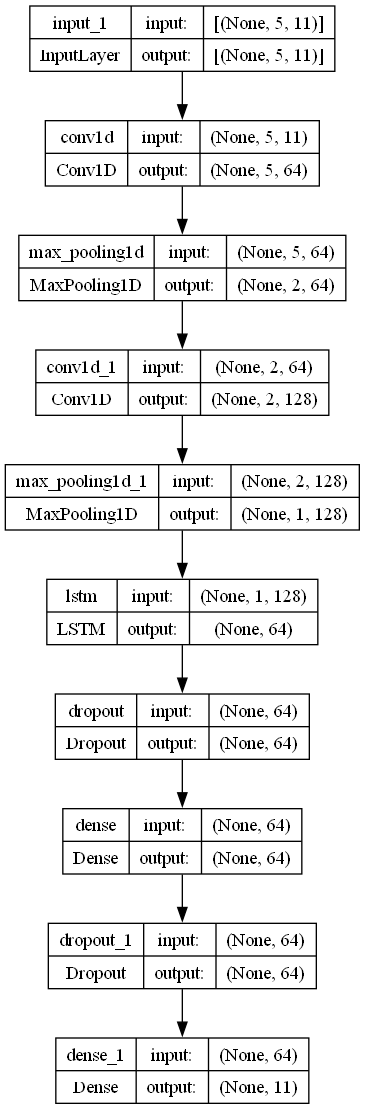

In [2]:
from tensorflow.keras.utils import plot_model
import os

# Ensure the directory exists for saving the plot
output_dir = "model_plots"
os.makedirs(output_dir, exist_ok=True)

# Path to save the model plot
plot_path = os.path.join(output_dir, "model_architecture.png")

# Generate and save the plot
plot_model(model, to_file=plot_path, show_shapes=True, show_layer_names=True, dpi=96)

# Display the saved plot (optional, if running in an environment like Jupyter Notebook)
from IPython.display import Image
Image(filename=plot_path)


In [80]:
# # Split the data into training and testing sets (if not already done)
# from sklearn.model_selection import train_test_split

# # Assuming `X` and `y` are already prepared
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
history = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_test, y_test), 
    epochs=30,  # Adjust based on convergence
    batch_size=32,  # Adjust based on available resources
    verbose=1
)



# Evaluate the model
loss, mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss}, Test MAE: {mae}")


Epoch 1/30
3/3 [==============================] - 3s 266ms/step - loss: 0.2791 - mae: 0.4120 - val_loss: 0.2393 - val_mae: 0.3862
Epoch 2/30
3/3 [==============================] - 0s 18ms/step - loss: 0.2361 - mae: 0.3782 - val_loss: 0.1959 - val_mae: 0.3538
Epoch 3/30
3/3 [==============================] - 0s 26ms/step - loss: 0.1947 - mae: 0.3518 - val_loss: 0.1532 - val_mae: 0.3170
Epoch 4/30
3/3 [==============================] - 0s 26ms/step - loss: 0.1606 - mae: 0.3237 - val_loss: 0.1254 - val_mae: 0.2855
Epoch 5/30
3/3 [==============================] - 0s 28ms/step - loss: 0.1456 - mae: 0.3073 - val_loss: 0.1084 - val_mae: 0.2628
Epoch 6/30
3/3 [==============================] - 0s 30ms/step - loss: 0.1389 - mae: 0.2943 - val_loss: 0.0954 - val_mae: 0.2427
Epoch 7/30
3/3 [==============================] - 0s 24ms/step - loss: 0.1212 - mae: 0.2721 - val_loss: 0.0897 - val_mae: 0.2294
Epoch 8/30
3/3 [==============================] - 0s 25ms/step - loss: 0.1176 - mae: 0.2699 - va

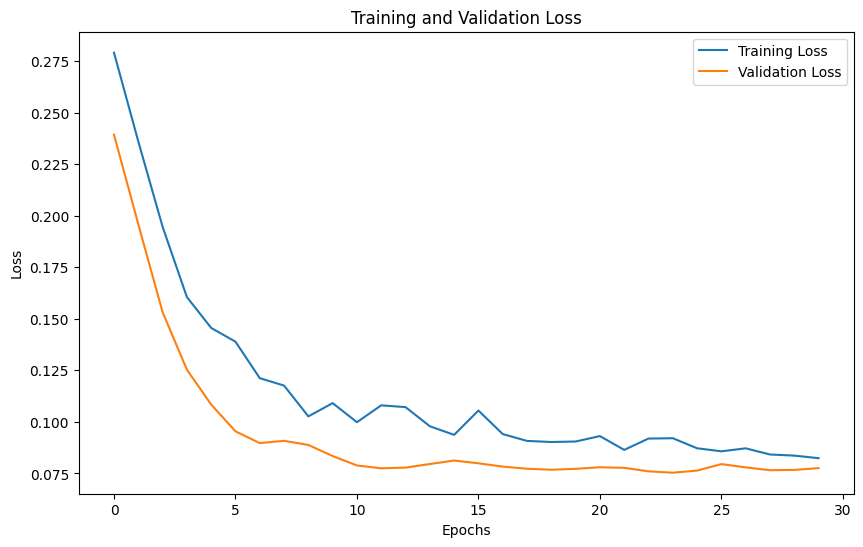

In [81]:
import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [82]:
# Predict the next song's features using the trained model
sample_sequence = X_test[0].reshape(1, sequence_length, num_features)  # Reshape to match input shape
predicted_features = model.predict(sample_sequence)

print("Predicted Features:", predicted_features)
print("Actual Features:", y_test[0])


1/1 [==============================] - 1s 627ms/step
Predicted Features: [[0.4560795  0.4382213  0.4769516  0.7176318  0.5375311  0.1137436
  0.21899244 0.047356   0.18884659 0.39860848 0.32993186]]
Actual Features: [0.40619621 0.62770563 0.81818182 0.87959077 1.         0.31533269
 0.34605715 0.         0.10035784 0.69120879 0.75095948]


In [84]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Function to recommend next songs based on input song name
def recommend_next_songs(input_song_name, model, music_df, audio_features, scaler, sequence_length=5, num_recommendations=5):
    # Ensure the input song exists in the dataset
    if input_song_name not in music_df['Track Name'].values:
        raise ValueError(f"'{input_song_name}' not found in the dataset.")

    # Get the input song's features
    input_features = get_song_features(input_song_name, music_df, audio_features)
    if input_features is None:
        raise ValueError(f"Features for '{input_song_name}' could not be extracted.")

    # Initialize the sequence with the input song's features
    input_sequence = [input_features]
    
    # List to hold the recommended songs and track duplicates
    recommended_songs = []
    seen_songs = set([input_song_name])  # Start with the current song already in the seen list
    
    # Iterate to generate the required number of recommendations
    iteration_count = 0
    while len(recommended_songs) < num_recommendations and iteration_count < 20:  # Limit iterations to avoid infinite loops
        iteration_count += 1
        
        # Ensure the sequence length is within bounds
        if len(input_sequence) > sequence_length:
            input_sequence = input_sequence[1:]  # Keep only the last 'sequence_length' songs
        
        # Pad the sequence if it's shorter than the required length
        if len(input_sequence) < sequence_length:
            padding = [[0] * len(audio_features)] * (sequence_length - len(input_sequence))
            input_sequence = padding + input_sequence

        # Prepare the input sequence for the model
        input_sequence_scaled = scaler.transform(np.array(input_sequence))  # Scale the sequence
        input_sequence_scaled = np.array([input_sequence_scaled])  # Add batch dimension

        # Predict the next song's features
        predicted_features_scaled = model.predict(input_sequence_scaled)

        # Inverse transform the predicted features to the original scale
        predicted_features = scaler.inverse_transform(predicted_features_scaled)

        # Find the closest song in the dataset based on cosine similarity
        similarities = cosine_similarity(predicted_features, music_df[audio_features].values)
        closest_song_index = np.argmax(similarities)

        # Get the recommended song's name and URL
        recommended_song_name = music_df['Track Name'].iloc[closest_song_index]
        recommended_song_url = music_df['External URLs'].iloc[closest_song_index]

        # Avoid recommending the same song again
        if recommended_song_name not in seen_songs:
            recommended_songs.append((recommended_song_name, recommended_song_url))
            seen_songs.add(recommended_song_name)

        # Update the sequence with the predicted features
        input_sequence.append(predicted_features[0])

    # Fallback: If still fewer recommendations, pick the closest songs based on cosine similarity from the entire dataset
    if len(recommended_songs) < num_recommendations:
        all_songs = music_df['Track Name'].tolist()
        remaining_songs = [song for song in all_songs if song not in seen_songs]
        for song in remaining_songs[:num_recommendations - len(recommended_songs)]:
            song_index = music_df[music_df['Track Name'] == song].index[0]
            recommended_song_url = music_df['External URLs'].iloc[song_index]
            recommended_songs.append((song, recommended_song_url))
    
    return recommended_songs

# Example usage
input_song_name = "Blinding Lights"  # Replace with an actual song name from your dataset
recommended_songs = recommend_next_songs(input_song_name, model, music_df, audio_features, scaler, sequence_length=5, num_recommendations=5)

# Display recommended songs (only title and URL)
if recommended_songs:
    print(f"Recommended songs after '{input_song_name}':")
    for song, url in recommended_songs:
        print(f"{song} - {url}")
else:
    print("No recommendations found.")


1/1 [==============================] - 0s 25ms/step
Recommended songs after 'Blinding Lights':
Photograph - https://open.spotify.com/track/1HNkqx9Ahdgi1Ixy2xkKkL
lovely (with Khalid) - https://open.spotify.com/track/0u2P5u6lvoDfwTYjAADbn4
Bohemian Rhapsody - Remastered 2011 - https://open.spotify.com/track/4u7EnebtmKWzUH433cf5Qv
Shape of You - https://open.spotify.com/track/7qiZfU4dY1lWllzX7mPBI3
Someone You Loved - https://open.spotify.com/track/7qEHsqek33rTcFNT9PFqLf


In [85]:
# Save the model
model.save('music_recommendation_model.h5')  # Saves the model in HDF5 format



c:\Users\tiuyy\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
